In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(7,5)
# Add the application folder to the path
import sys
sys.path.insert(0,'../Peergrade/peergrade/')
import time
import math
from application.model import data_model
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.stats import norm

SERVER_NAME: localhost:5000


In [3]:
fig_store = "../MasterThesis/Thesis/figures/ModelsOfPeer/"

In [4]:
def tau_std(value):
    return np.sqrt(1.0 / value)

In [102]:
class Grader_(object):
    def __init__(self, id):
        self.id = id
        self.handins = list()
    def set_bias(self, mean, precision):
        self.mean = mean
        self.precision = precision
    
    def get_bias(self):
        return np.random.normal(self.mean,tau_std(self.precision))
        
    def add_handin(self, handin):
        self.handins.append(handin)

    def grade_handins(self,questions,n_v):
        for handin in self.handins:
            for question in questions.itervalues():
                handin.add_mock_gradeing(question,self,n_v)
                
class Question_(object):
    def __init__(self,id):
        self.id = id
                
class Answers_(object):
    def __init__(self,handin,question):
        self.handin = handin
        self.question = question
        self.answers = dict()
    
    def set_mock_value(self,mean,precision):
        self.mean = mean
        self.precision = precision
        
    def set_mock_score(self,grader,score):
        self.answer[str(question)] = score

    def get_score(self):
        return self.mean

class Handin_(object):
    def __init__(self,id,owner):
        self.id = id
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.catched_score = dict()
        self.precision = np.random.gamma(10,1.0/ 0.1)
        while 1:
            h_mu = np.random.normal(0.5,tau_std(np.random.gamma(2,1.0/ 0.1)))
            if h_mu < 1.0 and h_mu > 0.0:
                break
        self.mean = h_mu
            
    def set_answers_scores(self):
        for gradeings in self.gradeings.itervalues():
            while 1:
                h_mu = np.random.normal(self.mean,tau_std(20.0))
                if h_mu < 1.0 and h_mu > 0.0:
                    break
            answer.set_mock_score(h_mu,np.random.gamma(1,1.0/ 0.1))
            
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_answer(self,grader,question,value):
        if str(question.id) not in self.gradeings:
            self.gradeings[str(question.id)] = Answers_(self,grader)
        self.gradeings[str(question.id)].answers[str(grader.id)] = value
        
    def get_graders_answers(self):
        graders_answers = defaultdict(list)
        for q, answer in self.gradeings.iteritems():
            for g, value in answer.answers.iteritems():
                graders_answers[str(g)].append((str(q),value))
            
        return graders_answers
        
    def get_grader_answers(self,grader):
        grader_answers = list()
        for key, answer in self.gradeings.iteritems():
            grader_answers.append((key,answer.answers[grader]))
        return grader_answers
    
    def get_handin_score(self,g):
        if g not in self.catched_score:
            grader_g = list()
            for answers in self.gradeings.itervalues():
                if g not in  answers.answers:
                    return None
                grader_g.append(answers.answers[g])
            self.catched_score[g] = np.mean(grader_g)
        
        return self.catched_score[g]
    
    def add_mock_gradeing(self,question,grader,n_v):
        if question.id not in self.gradeings:
            a = Answers_(self,question)
            while 1:
                a_mu = np.random.normal(self.mean,tau_std(self.precision))
                if a_mu < 1.0 and a_mu > 0.0:
                    break
            a.set_mock_value(a_mu,np.random.gamma(100,1.0/ 0.1))
            self.gradeings[str(question.id)] = a
        a = self.gradeings[str(question.id)]
        while 1:
            mock_value = np.random.normal(a.get_score()+grader.get_bias(),tau_std(n_v))
#            if mock_value < 1.0 and mock_value > 0.0:
            break
        a.answers[str(grader.id)] = mock_value

class Assignment_(object):
    
    def __init__(self, handins_input, graders_input, questions_input, n_gradings):
        self.graders = dict()
        self.handins = dict()
        self.questions = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[str(handin.id)] = handin
        for grader in graders_input:
            self.graders[str(grader.id)] = grader
        for question in questions_input:
            self.questions[str(question.id)] = question

    def add_handin(self, handin):
        self.handing[str(handin.id)] = handin
        
    def add_grader(self, grader):
        self.graders[str(grader.id)] = grader
    
    def set_questions(self, questions):
        self.questions = list(questions)
        
    def grade_mock_handins(self,n_gradings,n_v):
        self.n_gradings = n_gradings
        # Distribute handins
        for i in xrange(0,n_gradings):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(grader)
                grader.add_handin(h)
        
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins(self.questions,n_v)
            
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.id == grader.id):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin


In [77]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def user_id(user_name):
    for user in data_model.User.objects(name=user_name):
        return user.id

def question_text(q_id):
    user = data_model.Question.objects.get(id=ObjectId(q_id))
    return user.text

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            return max(map(int,question.numericalAnswers.keys()))
        else:
            return 1

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def answeres_handin(report_grade):
    '''Returns a list of tuples containing the answer and the value of the question'''
    answers = data_model.Answer.objects(report_grade=report_grade)
    result = list()
    for answer in answers:
        if answer.numerical_answer != None or answer.boolean_answer != None:
            result.append((answer,answer_value(answer)))
    return result

In [211]:
handins_data = list()
graders_data = list()
questions_data = list()
answers_data = list()

graders = 100
questions = 20
gradings = 5

for i in xrange(questions):
    q = Question_('question_%i' % i)
    questions_data.append(q)

for i in xrange(graders):
    g = Grader_('grader_%i' % i)
    g.set_bias(np.random.normal(0,tau_std(100)),np.random.gamma(50,1.0 / 0.1))
    h = Handin_('handin_%i' % i, g)
    h.set_answers_scores()
    graders_data.append(g)
    handins_data.append(h)
    
mock_data = Assignment_(handins_data,graders_data,questions_data,graders*gradings)
mock_data.grade_mock_handins(gradings,np.random.gamma(50,1.0 / 0.1))

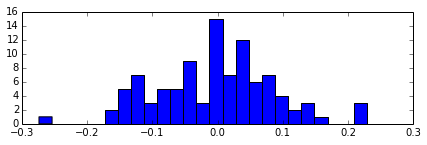

In [212]:
figsize(7,2)
plt.hist([x.mean for x in mock_data.graders.values()],bins=25)
plt.show()

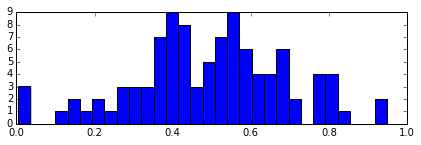

In [213]:
figsize(7,2)
plt.hist([x.mean for x in mock_data.handins.values()],bins=30)
plt.show()

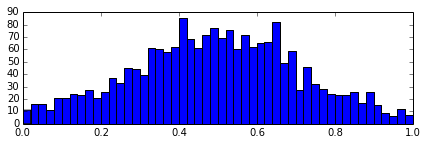

In [214]:
figsize(7,2)
q_scores = list()
for handin in mock_data.handins.itervalues():
    for answer in handin.gradeings.itervalues():
        q_scores.append(answer.mean)
plt.hist(q_scores,bins=50)
plt.show()

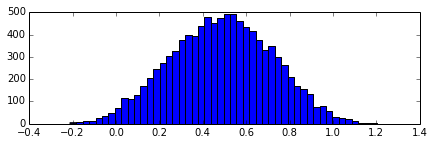

In [215]:
figsize(7,2)
q_scores = list()
for handin in mock_data.handins.itervalues():
    for answer in handin.gradeings.itervalues():
        q_scores.extend(answer.answers.values())
plt.hist(q_scores,bins=50)
plt.show()

In [75]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))-np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t)-0.5*t*la*(u-ga)**2

In [54]:
def MH_model(data,samples,burn_in=0):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    
    log_h = dict()
    log_g = dict()

    def prop_u_t_h(handin,u_h,t_h):
        sum_ = 0.0
        for g in handin.graders:
            val = handin.get_handin_score(g.id)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g[g.id]+u_h,t_g[g.id]+t_h)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.get_handin_score(g)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g+u_h[h.id],t_g+t_h[h.id])
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    
    # Draw from priors
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
    # pre calcuate the liklyhood
    for h, handin in data.handins.iteritems():
        log_h[h] = prop_u_t_h(handin,u_h[h],t_h[h])
    for g, grader in data.graders.iteritems():
        log_g[g] = prop_u_t_g(grader,g,u_g[g],t_g[g])
            
    # Tracers initialising
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in data.handins.iterkeys():
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in data.graders.iterkeys():
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}

    return traces

In [55]:
def gibbs_model(data, samples, burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_Q = len(data.questions) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_n = 10.0
    be_n = 1.0
    

    # Gibbs sampling #    
    # Tracers initialising
    acc_e = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(list)
    acc_B = defaultdict(list)

    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    T = dict()
    B = dict()

    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
            
    # Gibbs sampling #
    
    # Tracers initialising
    acc_n_v = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(list)
    acc_B = defaultdict(list)

    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample T
        for h, handin in data.handins.iteritems():
            n_gradings = len(handin.graders)
            sum_ = 0.0
            for g in handin.graders:
                sum_ = sum_ + handin.get_handin_score(g.id) - B[g.id]
            v = n_v*n_gradings+t_h[h]
            T[h] = np.random.normal((u_h[h]*t_h[h]+n_v*sum_)/v,np.sqrt(1.0/v))

        # Sample B
        for g, grader in data.graders.iteritems():
            n_gradings = len(grader.handins)
            sum_ = 0.0
            for h in grader.handins:
                sum_ = sum_ + h.get_handin_score(g) - T[h.id]
            v = n_v*n_gradings+t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+n_v*sum_)/v,np.sqrt(1.0/v))

        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for grader in handin.graders:
                n_eval = n_eval + 1
                sum_ = sum_ + np.square(handin.get_handin_score(grader.id) - (T[h]+B[grader.id]))
        n_v = np.random.gamma(al_n+0.5*n_eval,1.0 / (be_n+0.5*sum_))

        # Sample u_h and t_h
        for h in data.handins.iterkeys():
            la_ = (la_h+1.0)
            al_ = al_h+0.5
            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0/be_)
            u_h[h] = np.random.normal((la_h*ga_h+T[h])/la_,np.sqrt(1.0 / (la_*t_h[h])))

        
        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+1.0)
            al_ = al_g+0.5
            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0 / (la_*t_g[g])))
                        
        # Collect tracings
        if r > burn_in:
            acc_n_v.append(n_v)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                acc_T[h].append(T[h])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g]) 
                acc_B[g].append(B[g])
                    
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'n_v' : acc_n_v,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [56]:
def gibbs_ext_model(data, samples, burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_Q = len(data.questions) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_n = 10.0
    be_n = 1.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    T = defaultdict(dict)
    B = defaultdict(dict)
    u_g = dict()
    t_g = dict()

    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        for q in data.questions.iterkeys():        
            T[h][q] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        for q in data.questions.iterkeys():
            B[str(g)][str(q)] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
            
    # Gibbs sampling #
    
    # Tracers initialising
    acc_n_v = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(lambda: defaultdict(list))
    acc_B = defaultdict(lambda: defaultdict(list))

    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                n_gradings = len(answers.answers)
                sum_ = 0.0
                for g, val in answers.answers.iteritems():
                    sum_ = sum_ + val - B[str(g)][str(q)]
                v = n_v*n_gradings+t_h[h]
                T[h][q] = np.random.normal((u_h[h]*t_h[h]+n_v*sum_)/v,np.sqrt(1.0/v))
            
        # Sample B
        for g, grader in data.graders.iteritems():
            for q in data.questions.iterkeys():
                n_gradings = len(grader.handins)
                sum_ = 0.0
                for h in grader.handins:
                    if g in h.gradeings[q].answers:
                        sum_ = sum_ + h.gradeings[q].answers[g] - T[h.id][q]
                v = n_v * n_gradings + t_g[g]
                B[g][q] = np.random.normal((u_g[g]*t_g[g]+n_v*sum_)/v,np.sqrt(1.0/v))
        
        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                for g, answer_val in answers.answers.iteritems():
                    n_eval = n_eval + 1
                    sum_ = sum_ + np.square(answer_val - (T[h][q]+B[g][q]))
        n_v = np.random.gamma(al_n+0.5*n_eval,1.0 / (be_n+0.5*sum_))

        # Sample u_q and t_q
        for h in data.handins.iterkeys():
            la_ = (la_h+N_Q)
            sum_q = np.sum(T[h].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(T[h][q]-mean_q)
            al_ = al_h+0.5*N_Q
            be_ = be_h+0.5*(N_Q*sum_minus+(N_Q*la_h*np.square(mean_q-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0 / be_)
            u_h[h] = np.random.normal((la_h*ga_h+sum_q)/la_,np.sqrt(1.0/(la_*t_h[h])))

        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+N_Q)
            sum_q = np.sum(B[g].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(B[g][q]-mean_q)
            al_ = al_g+0.5*N_Q
            be_ = be_g+0.5*(N_Q*sum_minus+(N_Q*la_g*np.square(mean_q-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0 / be_)
            u_g[g] = np.random.normal((la_g*ga_g+sum_q)/la_,np.sqrt(1.0/(la_*t_g[g])))
                        
        # Collect tracings
        if r > burn_in:
            acc_n_v.append(n_v)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                for q in data.questions.iterkeys():
                    acc_T[h][q].append(T[h][q])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g])
                for q in data.questions.iterkeys():
                    acc_B[g][q].append(B[g][q])
                    
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'n_v' : acc_n_v,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [222]:
mock_gibbs_result = gibbs_model(mock_data,5000,1000)

6000 out of 6000
Wall time: 39.366136


In [218]:
mock_gibbs_ext_result = gibbs_ext_model(mock_data,5000,1000)

6000 out of 6000
Wall time: 613.732715


In [219]:
mock_MH_result = MH_model(mock_data,10000,1000)

11000 out of 11000
Wall time: 174.732695


In [26]:
def truncate(string,length):
    return (string[:length] + '..') if len(string) > length else string

In [27]:
def handin_students(h_id):
    model_handin = data_model.Handin.objects.get(id=ObjectId(h_id))
    students_ = list()
    for student in model_handin.students:
        students_.append(student.name)
    return ", ".join(students_)

In [28]:
def MAE(true,estimated):
    return np.mean(map(lambda x : abs((x[1] - x[0])),zip(true,estimated)))

In [29]:
def plot_handins(t,results,nth=1):

    colors = ["#A60628","#348ABD","#7A68A6","#467821","m","c"]
    labels = list()
    for (name,data) in results:
        labels.append(name)
        
    scores = list()
    for id, g in t.handins.iteritems():
        text = id
        val = list()
        for (name,data) in results:
            val.append(np.mean(data['u_h'][id]))
        obs_scores = list()
        for grader in t.handins[id].graders:
            obs_scores.extend(map(lambda x : x[1],t.handins[id].get_grader_answers(grader.id)))
        scores.append((text,val,np.mean(data['u_h'][id]),t.handins[id].mean,obs_scores))
    scores.sort(key=lambda x:x[3]) 
    scores_ = scores[::nth]

    y = xrange(0,len(scores_))
    true_score_ = map(lambda x : x[3],scores_)    
    true_score = map(lambda x : x[3],scores)    
    for i in xrange(len(results)):
        x = map(lambda x : x[1][i],scores)
        x_ = map(lambda x : x[1][i],scores_)
        print "MAE %s: %f" % (labels[i], MAE(true_score,x))
        plt.plot(x_,y,'o',color=colors[i],label=labels[i],alpha=0.65)

    plt.plot(true_score_,y,'x',color='black',label="True score")
    obs_score_ = map(lambda x : x[4],scores_)
    for i, ob in enumerate(obs_score_):
        if i == 0:
            plt.plot(ob,[y[i]]*len(ob),'.',color='gray',alpha=0.1,label="Obs scores")
            plt.plot(np.mean(ob),y[i],'.',color='black',label="Average obs score")
        else:
            plt.plot(ob,[y[i]]*len(ob),'.',color='gray',alpha=0.1)
            plt.plot(np.mean(ob),y[i],'.',color='black')
    obs_score = map(lambda x : x[4],scores)
    print "MAE %s: %f" % ("Observed average score", MAE(true_score,map(lambda x : np.mean(x),obs_score)))
                      
    ylabel = map(lambda x : x[0],scores_)    
    plt.yticks(xrange(0,len(scores)),ylabel)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Score of the handins")
#    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Handin")
    plt.xlabel("Score")
    plt.margins(0.02)
    plt.show()

In [30]:
def plot_bias(t,results,nth=1):

    colors = ["#A60628","#348ABD","#7A68A6","#467821","m","c"]
    labels = list()
    for (name,data) in results:
        labels.append(name)
        
    scores = list()
    for id, g in t.graders.iteritems():
        text = id
        text = text + ": %i" % len(t.graders[id].handins)
        val = list()
        for (name,data) in results:
            val.append(np.mean(data['u_g'][id]))
        scores.append((text,val,np.mean(data['u_g'][id]),t.graders[id].mean))
    scores.sort(key=lambda x:x[3])        
    scores_ = scores[::nth]
    
    y = xrange(0,len(scores_))
    true_bias = map(lambda x : x[3],scores)
    true_bias_ = map(lambda x : x[3],scores_)
    for i in xrange(len(results)):
        x = map(lambda x : x[1][i],scores)
        x_ = map(lambda x : x[1][i],scores_)
        print "MAE %s: %f" % (labels[i], MAE(true_bias,x))
        plt.plot(x_,y,'o',color=colors[i],label=labels[i],alpha=0.65)
    plt.plot(true_bias_,y,'x',color='black',label="True bias")
    
    ylabel = map(lambda x : x[0],scores_)
    plt.yticks(xrange(0,len(scores)),ylabel)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Bias of the graders")
    plt.vlines(0, 0, len(scores_)-1, color="k", linestyles="--", lw=1)
    plt.ylabel("Grader : [Graded handins]")
    plt.xlabel("Bias")
    plt.margins(0.02)
    plt.show()

MAE Gibbs: 0.049466
MAE Ext. Gibbs: 0.020835
MAE MH: 0.029747


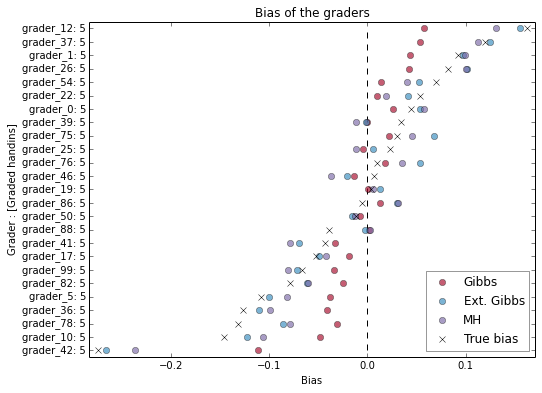

In [223]:
#with PdfPages(fig_store + "Failed_Mock_Bias.pdf") as pdf:
fig = plt.figure(figsize(8,6))
plot_bias(mock_data,[("Gibbs",mock_gibbs_result),("Ext. Gibbs",mock_gibbs_ext_result),("MH",mock_MH_result)],nth=4)
#    pdf.savefig(fig)

MAE Gibbs: 0.088396
MAE Ext. Gibbs: 0.036931
MAE MH: 0.042789
MAE Observed average score: 0.044283


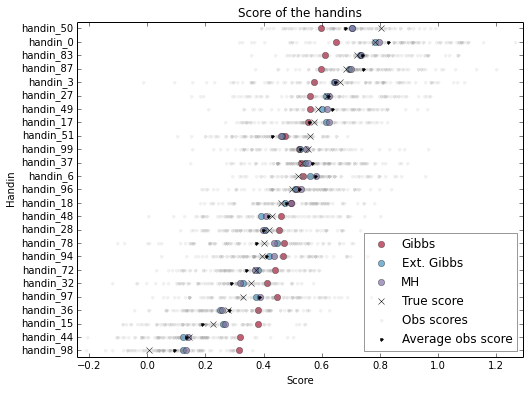

In [224]:
#with PdfPages(fig_store + "Failed_Mock_Handin_Score.pdf") as pdf:
fig = plt.figure(figsize(8,6))
plot_handins(mock_data,[("Gibbs",mock_gibbs_result),("Ext. Gibbs",mock_gibbs_ext_result),("MH",mock_MH_result)],nth=4)
#    pdf.savefig(fig)

MAE Gibbs: 0.049466
MAE Ext. Gibbs: 0.020835
MAE MH: 0.029747


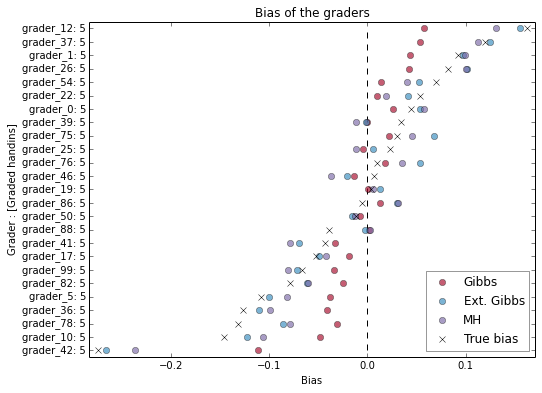

In [226]:
with PdfPages(fig_store + "ModelCompareGraderBias.pdf") as pdf:
    fig = plt.figure(figsize(8,6))
    plot_bias(mock_data,[("Gibbs",mock_gibbs_result),("Ext. Gibbs",mock_gibbs_ext_result),("MH",mock_MH_result)],nth=4)
    pdf.savefig(fig,bbox_inches='tight')

MAE Gibbs: 0.088396
MAE Ext. Gibbs: 0.036931
MAE MH: 0.042789
MAE Observed average score: 0.044283


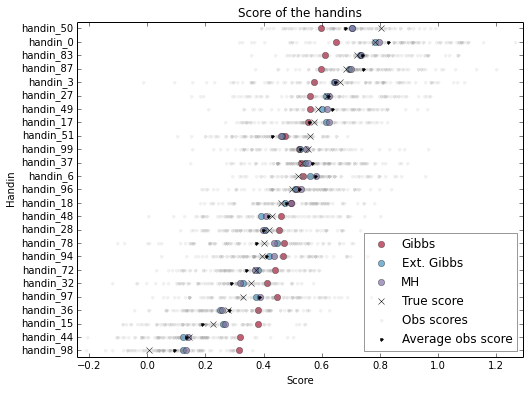

In [227]:
with PdfPages(fig_store + "ModelCompareHandinScore.pdf") as pdf:
    fig = plt.figure(figsize(8,6))
    plot_handins(mock_data,[("Gibbs",mock_gibbs_result),("Ext. Gibbs",mock_gibbs_ext_result),("MH",mock_MH_result)],nth=4)
    pdf.savefig(fig,bbox_inches='tight')

In [229]:
def plot_bias_precision(t,results,nth=1):

    colors = ["#A60628","#348ABD","#7A68A6","#467821","m","c"]
    labels = list()
    for (name,data) in results:
        labels.append(name)
        
    scores = list()
    for id, g in t.graders.iteritems():
        text = id
        text = text + ": %i" % len(t.graders[id].handins)
        val = list()
        for (name,data) in results:
            val.append(np.mean(data['t_g'][id]))
        scores.append((text,val,np.mean(data['t_g'][id]),t.graders[id].precision))
    scores.sort(key=lambda x:x[3])        
    scores_ = scores[::nth]
    
    y = xrange(0,len(scores_))
    true_bias = map(lambda x : x[3],scores)
    true_bias_ = map(lambda x : x[3],scores_)
    for i in xrange(len(results)):
        x = map(lambda x : x[1][i],scores)
        x_ = map(lambda x : x[1][i],scores_)
        print "MAE %s: %f" % (labels[i], MAE(true_bias,x))
        plt.plot(x_,y,'o',color=colors[i],label=labels[i],alpha=0.65)
    plt.plot(true_bias_,y,'x',color='black',label="True bias")
    
    ylabel = map(lambda x : x[0],scores_)
    plt.yticks(xrange(0,len(scores)),ylabel)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Precision of graders bias")
#    plt.vlines(0, 0, len(scores_)-1, color="k", linestyles="--", lw=1)
    plt.ylabel("Grader : [Graded handins]")
    plt.xlabel("precision")
    plt.margins(0.02)
    plt.show()

In [230]:
def plot_handins_precision(t,results,nth=1):

    colors = ["#A60628","#348ABD","#7A68A6","#467821","m","c"]
    labels = list()
    for (name,data) in results:
        labels.append(name)
        
    scores = list()
    for id, g in t.handins.iteritems():
        text = id
        val = list()
        for (name,data) in results:
            val.append(np.mean(data['t_h'][id]))
        scores.append((text,val,np.mean(data['t_h'][id]),t.handins[id].precision))
    scores.sort(key=lambda x:x[3])
    scores_ = scores[::nth]
    print len(scores_)

    y = xrange(0,len(scores_))
    true_score_ = map(lambda x : x[3],scores_)    
    true_score = map(lambda x : x[3],scores)
    for i in xrange(len(results)):
        x = map(lambda x : x[1][i],scores)
        x_ = map(lambda x : x[1][i],scores_)
        print "MAE %s: %f" % (labels[i], MAE(true_score,x))
        plt.plot(x_,y,'o',color=colors[i],label=labels[i],alpha=0.65)

    plt.plot(true_score_,y,'x',color='black',label="True score")
                      
    ylabel = map(lambda x : x[0],scores_)    
    plt.yticks(xrange(0,len(scores)),ylabel)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Precision of the handin scores")
#    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Handin")
    plt.xlabel("Precision")
    plt.margins(0.02)
    plt.show()

MAE Gibbs: 49.453040
MAE Ext. Gibbs: 393.616606
MAE MH: 74.609717


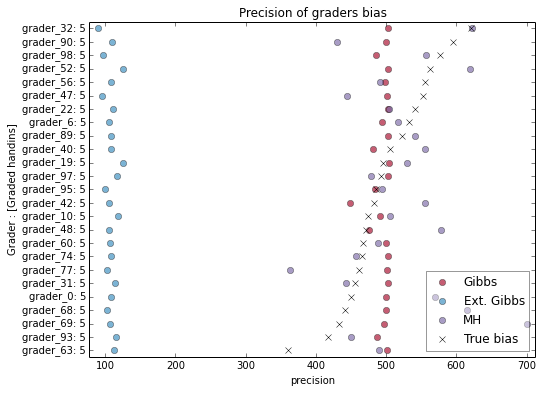

In [231]:
with PdfPages(fig_store + "ModelCompareGraderBiasPrecision.pdf") as pdf:
    fig = plt.figure(figsize(8,6))
    plot_bias_precision(mock_data,[("Gibbs",mock_gibbs_result),("Ext. Gibbs",mock_gibbs_ext_result),("MH",mock_MH_result)],nth=4)
    pdf.savefig(fig,bbox_inches='tight')

25
MAE Gibbs: 24.952580
MAE Ext. Gibbs: 89.260031
MAE MH: 38.462509


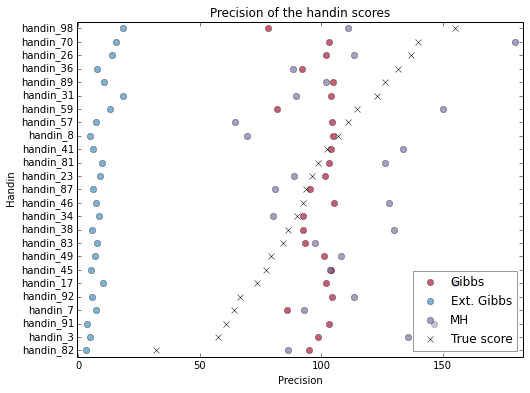

In [232]:
with PdfPages(fig_store + "ModelCompareHandinScorePrecision.pdf") as pdf:
    fig = plt.figure(figsize(8,6))
    plot_handins_precision(mock_data,[("Gibbs",mock_gibbs_result),("Ext. Gibbs",mock_gibbs_ext_result),("MH",mock_MH_result)],nth=4)
    pdf.savefig(fig,bbox_inches='tight')

In [233]:
fig_store = "../MasterThesis/Thesis/figures/Analysis/"

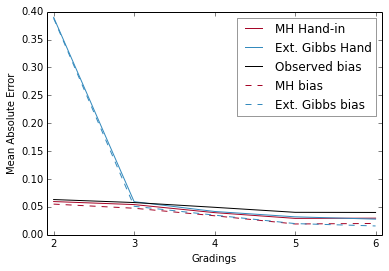

In [239]:
gradings = [2,3,4,5,6]
MH_bias = map(lambda x : np.mean(x),
          [[0.0585,0.049781,0.056716],
           [0.0516,0.042887,0.048382],
           [0.02958,0.043392,0.029369],
           [0.0205,0.018222,0.019511],
           [0.024895,0.019772,0.016363]])
MH_hand = map(lambda x : np.mean(x),
          [[0.0537,0.061553,0.063526],
           [0.05987,0.048783,0.053834],
           [0.036927,0.049484,0.032797],
           [0.036927,0.026108,0.025284],
           [0.034147,0.029796,0.025484]])
Gibbs_bias= map(lambda x : np.mean(x),
            [[0.3922,0.390533,0.381411],
             [0.051239,0.049055,0.052992],
             [0.037448,0.042574,0.025626],
             [0.037448,0.013469,0.009360],
             [0.024377,0.013095,0.010103]])
Gibbs_hand = map(lambda x : np.mean(x),
             [[0.3917,0.393518,0.383856],
              [0.058022,0.057864,0.062176],
              [0.045901,0.046495,0.032975],
              [0.045901,0.025843,0.024924],
              [0.034456,0.027350,0.022468]])
Obs_hand = map(lambda x : np.mean(x),
            [[0.05715,0.062070,0.070334],
            [0.06015,0.054969,0.058296],
            [0.041809,0.061696,0.044254],
            [0.0413027,0.036917,0.042627],
            [0.041588,0.039275,0.039227]])



with PdfPages(fig_store + "ModelsErrorGradings.pdf") as pdf:
    fig = plt.figure(figsize(6,4))
    plt.plot(gradings,MH_hand,label="MH Hand-in",color="#A60628")
    plt.plot(gradings,Gibbs_hand,label="Ext. Gibbs Hand",color="#348ABD")
    plt.plot(gradings,Obs_hand,label="Observed bias",color="black")
    plt.plot(gradings,MH_bias,'--',label="MH bias",color="#A60628")
    plt.plot(gradings,Gibbs_bias,'--',label="Ext. Gibbs bias",color="#348ABD")
    leg = plt.legend(loc=1)
    leg.get_frame().set_alpha(0.4)
    plt.xticks(gradings,gradings)
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("Gradings")
    plt.margins(0.02)
    plt.ylim(0,0.4)
    plt.show()
    pdf.savefig(fig,bbox_inches='tight')

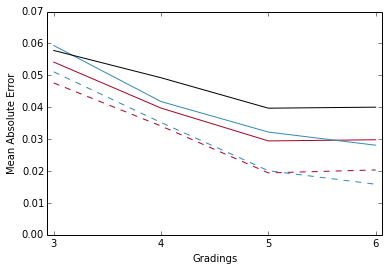

In [236]:
gradings = [3,4,5,6]
MH_bias = map(lambda x : np.mean(x),
          [[0.0516,0.042887,0.048382],
           [0.02958,0.043392,0.029369],
           [0.0205,0.018222,0.019511],
           [0.024895,0.019772,0.016363]])
MH_hand = map(lambda x : np.mean(x),
          [[0.05987,0.048783,0.053834],
           [0.036927,0.049484,0.032797],
           [0.036927,0.026108,0.025284],
           [0.034147,0.029796,0.025484]])
Gibbs_bias= map(lambda x : np.mean(x),
            [[0.051239,0.049055,0.052992],
             [0.037448,0.042574,0.025626],
             [0.037448,0.013469,0.009360],
             [0.024377,0.013095,0.010103]])
Gibbs_hand = map(lambda x : np.mean(x),
             [[0.058022,0.057864,0.062176],
              [0.045901,0.046495,0.032975],
              [0.045901,0.025843,0.024924],
              [0.034456,0.027350,0.022468]])
Obs_hand = map(lambda x : np.mean(x),
            [[0.06015,0.054969,0.058296],
             [0.041809,0.061696,0.044254],
             [0.039512,0.044298,0.035315],
             [0.041588,0.039275,0.039227]])

with PdfPages(fig_store + "ModelsErrorGradings2.pdf") as pdf:
    fig = plt.figure(figsize(6,4))

    plt.plot(gradings,MH_hand,label="MH Hand-in",color="#A60628")
    plt.plot(gradings,Gibbs_hand,label="Ext. Gibbs Hand",color="#348ABD")
    plt.plot(gradings,Obs_hand,label="Observed bias",color="black")
    plt.plot(gradings,MH_bias,'--',label="MH bias",color="#A60628")
    plt.plot(gradings,Gibbs_bias,'--',label="Ext. Gibbs bias",color="#348ABD")
    #leg = plt.legend(loc=1)
    #leg.get_frame().set_alpha(0.4)
    plt.xticks(gradings,gradings)
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("Gradings")
    plt.ylim(0,0.07)
    plt.margins(0.02)
    plt.show()
    pdf.savefig(fig,bbox_inches='tight')

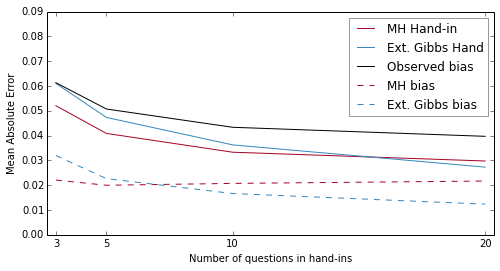

In [238]:
questions = [3,5,10,20]
Gibbs_bias= map(lambda x : np.mean(x),
            [[0.029861,0.031973,0.034049],
             [0.024866,0.019677,0.023413],
             [0.015033,0.021650,0.013258],
             [0.011695,0.013265,0.012129]])
MH_bias = map(lambda x : np.mean(x),
             [[0.018494,0.024277,0.023441],
              [0.021836,0.018335,0.019758],
              [0.019170,0.025675,0.017340],
              [0.020219,0.024752,0.020048]])
Gibbs_hand = map(lambda x : np.mean(x),
          [[0.059987,0.058260,0.064828],
           [0.048201,0.047076,0.046708],
           [0.037602,0.038202,0.032955],
           [0.025413,0.030629,0.025821]])
MH_hand = map(lambda x : np.mean(x),
          [[0.052980,0.047201,0.055959],
           [0.039974,0.040193,0.042469],
           [0.034166,0.036228,0.029524],
           [0.027506,0.034120,0.027654]])
Obs_hand = map(lambda x : np.mean(x),
            [[0.060435,0.055756,0.067791],
             [0.047278,0.046438,0.058449],
             [0.042467,0.047497,0.040097],
             [0.039512,0.044298,0.035315]])

with PdfPages(fig_store + "ModelsErrorQuestions.pdf") as pdf:
    fig = plt.figure(figsize(8,4))

    plt.plot(questions,MH_hand,label="MH Hand-in",color="#A60628")
    plt.plot(questions,Gibbs_hand,label="Ext. Gibbs Hand",color="#348ABD")
    plt.plot(questions,Obs_hand,label="Observed bias",color="black")
    plt.plot(questions,MH_bias,'--',label="MH bias",color="#A60628")
    plt.plot(questions,Gibbs_bias,'--',label="Ext. Gibbs bias",color="#348ABD")
    leg = plt.legend(loc=1)
    leg.get_frame().set_alpha(0.4)
    plt.xticks(questions,questions)
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("Number of questions in hand-ins")
    plt.ylim(0,0.09)
    plt.margins(0.02)
    plt.show()
    pdf.savefig(fig,bbox_inches='tight')